### Optimising functions of the form $\ f(x,y)\ $.

__A mathematics and Python learning exercise - do not rely on this notebook.__

There has been little 'generalised' testing, i.e. there may be many cases that break down. 

In particular, I haven't tested that the function $\ f\ $ has __real__ stationary points.

DGMacA - current version 03 February 2023.

#### Unconstrained optimisation
1. Find stationary points of $f(x,y)$; they are evaluated and classified as `max`, `min` or `saddle`.

2. Plot the function and stationary points.

Examples with 

(a) $\,f(x,y) = x^2 + y^2\,$   -- 1 stationary point; 

(b) $\,f(x,y) = x^2y + xy^2 -3xy\,$ -- multiple stationary points.

Inputs are between the lines of asterisks.

Function to apply eigenvalue test to the Hessian matrix

In [1]:
def sptype(v1, v2): # Classify stationary points using the eigenvalue test
    if v1>0 and v2>0:   return 'Local minimum.'
    elif v1<0 and v2<0: return 'Local maximum.'
    else:               return 'Saddle point.'

Set up the function $\ f(x,y)\ $, find the stationary points, and plot.

I have found a problem and given a work-around  
  - if `solve` returns a dictionary, I _assume_ there is a single stationary point; 
  - otherwise `solve` returns a list.

In [2]:
from sympy import symbols, Function, diff, solve, Eq, Matrix
from sympy import lambdify, latex, sympify
import numpy as np, matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})

# Find the stationary points of f(x,y)
x, y = symbols('x y')
f   = Function('f')
#**************************************************
f = x**2*y + x*y**2 - 3*x*y    # multiple solutions
#f = x**2 + y**2 + 10          # one solution
clevel = 50           # no of contour lines to plot
#**************************************************
print('The function is   f(x,y) =', f)
fx, fy = f.diff(x), f.diff(y)
fxx, fxy, fyy = f.diff(x,x), f.diff(x,y), f.diff(y,y)
eq1, eq2 = Eq(fx, 0), Eq(fy, 0)
varsxy = [x, y]
s = solve([eq1, eq2], varsxy)   # solve for x, y

if isinstance(s, dict):  # only happens for a single solution??
    d = True
    ss = tuple(s.values())
    a, b = ss[0], ss[1]
    soln = tuple([a,b,f.subs(x,a).subs(y,b)])
    num = 1
else:
    d = False
    soln = []
    ss = [k for k in s]
    ls = len(ss)                  # number of solutions
    for i in range(ls):           # iterate and add function value
        a, b = s[i][0], s[i][1]
        soln.append((a, b, f.subs(x,a).subs(y,b)))
        num = len(soln)

The function is   f(x,y) = x**2*y + x*y**2 - 3*x*y


In [3]:
# Calculate Hessian matrix for each stationary point and find eigenvalues

flam = lambdify([x, y], f, 'numpy')
fxx = lambdify([x,y], fxx, 'numpy')
fyy = lambdify([x,y], fyy, 'numpy')
fxy = lambdify([x,y], fxy, 'numpy')

xmin, xmax, ymin, ymax = 10000, -10000, 10000, -10000 # use to get plot boundaries
print('\nThe', num, 'stationary point(s) of f(x,y) are:\n')

for i in range(num):                    # Stationary points
    if d == True:
        a,b = ss[0], ss[1]
    else:
        a, b = soln[i][0], soln[i][1]   # Coords of stationary point
    
    H = Matrix([[ fxx(a,b), fxy(a,b)],  # Hessian matrix
                [ fxy(a,b), fyy(a,b)]])
#    print(H)
    v = H.eigenvals(multiple=True)    # Eigenvalues
    print('     (',a,',',b,',',flam(a,b),') --  a',
          sptype(v[0], v[1]))   # Classification
    xmin, xmax = float(min(a, xmin)), float(max(a, xmax))
    ymin, ymax = float(min(b, ymin)), float(max(b, ymax))
print()
marginx = float(max(abs(xmin), abs(xmax), 2)) # arbitrary min size
marginy = float(max(abs(ymin), abs(ymax), 2))


The 4 stationary point(s) of f(x,y) are:

     ( 0 , 0 , 0 ) --  a Saddle point.
     ( 0 , 3 , 0 ) --  a Saddle point.
     ( 1 , 1 , -1 ) --  a Local minimum.
     ( 3 , 0 , 0 ) --  a Saddle point.



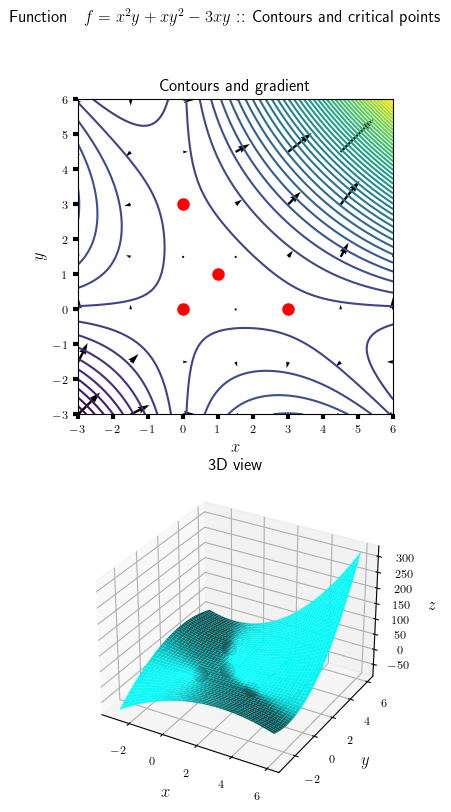

In [4]:
# Calculate gradient and find contours etc.

coarse = 100   # no of points to skip
coordsx = np.linspace(xmin-marginx, xmax+marginx, 601)
coordsy = np.linspace(ymin-marginy, ymax+marginy, 601)

Xc, Yc = np.meshgrid(coordsx[::coarse], coordsy[::coarse]) # coarse mesh
xf, yf = np.meshgrid(coordsx, coordsy)            # fine mesh

fc = flam(Xc, Yc)
ff = flam(xf, yf)
ds = coordsx[coarse] - coordsx[0]                # coarse mesh
dX, dY = np.gradient(fc, ds)                   # gradient

minff, maxff = np.min(ff), np.max(ff)
levels = np.linspace(minff, maxff, clevel)

latexf = latex(sympify(str(f)))   # Prettify the title
text1  = "Function\quad $ f ="
text2  = "$ :: Contours and critical points"
supt   = text1 + latexf + text2

fig = plt.figure(figsize=[8,9])
fig.suptitle(supt, fontsize=12)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_aspect('equal', adjustable='box')
ax1.contour(xf, yf, ff, levels=levels)          # fine mesh for contour plot
ax1.quiver(Xc, Yc, dX.transpose(), dY.transpose(), angles='xy',
           scale_units='xy', scale=50, color='k')

ax1.set_title("Contours and gradient", fontsize=12)
ax1.set_xlabel("$x$", fontsize=12)
ax1.set_ylabel("$y$", fontsize=12)
ax1.tick_params(labelcolor='k', labelsize='small', width=3)

ax2 = fig.add_subplot(2, 1, 2, projection='3d')
ax2.set_aspect('auto', adjustable='box')
ax2.set_zlim(minff, maxff)
ax2.plot_surface(xf, yf, ff, color="cyan")       # fine mesh for surface plot

for i in range(num):                             # cycle through stationary points
    if d == True:
        a,b = ss[0], ss[1]
    else:
        a, b = soln[i][0], soln[i][1]
    ax1.plot(a, b, "o", color="red", markersize=8)
    ax2.scatter(a, b, flam(a,b), marker="o", color="red", s=100)
    
ax2.set_title("3D view", fontsize=12)
ax2.set_xlabel("$x$", fontsize=12)
ax2.set_ylabel("$y$", fontsize=12)
ax2.set_zlabel("$z$", fontsize=12)
ax2.tick_params(labelcolor='k', labelsize='small', width=3)

plt.show()

#### Constrained optimisation
1. Find stationary points of $f(x,y)$ subject to constraint $g(x,y) --$ they are evaluated but not classified.

2. Plot the function, constraint and vertical lines though the stationary points.

Example with $\,f(x,y) = x^2 + y^2\,$ and the constraint $\,g(x,y) = xy-4\,$, i.e., $\,xy=4\,$.

Inputs are between the lines of asterisks.

In [5]:
from sympy import symbols, diff, solve, lambdify, latex, sympify
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
plt.rcParams.update({"text.usetex": True})

x, y = symbols('x y', real=True)

#**********************************************
f = x**2 + y**2          # function of x and y
g = x*y - 4              # constraint
#**********************************************

print('Expression to optimise       : f(x,y) = ', f)
print('Subject to constraint        :', g, '= 0 \n')

fx, fy = f.diff(x), f.diff(y) # partial derivatives
gx, gy = g.diff(x), g.diff(y) #

eq1 = fx*gy - fy*gx           # Lagrange set-up
eq2 = g                       # constraint

s = solve([eq1, eq2], [x, y]) # solve for x, y
s = [k for k in s]            # make into a list
ls = len(s)                   # number of solutions

soln = []
for i in range(ls):            # iterate and add function value
    a, b = s[i][0], s[i][1]
    soln.append((a, b, f.subs(x,a).subs(y,b)))

print('Stationary point(s) : ', soln, '.\n')

Expression to optimise       : f(x,y) =  x**2 + y**2
Subject to constraint        : x*y - 4 = 0 

Stationary point(s) :  [(-2, -2, 8), (2, 2, 8)] .



In [6]:
flam = lambdify([x, y], f, 'numpy')

yg = solve(g,y)   # solve constraint for y
l = len(yg)       # number of solutions - 1 or 2
if l==1:
    yy = yg[0]
    ylam = lambdify(x, yy, 'numpy')
elif l==2:
    yy1, yy2 = yg[0], yg[1]
    ylam1 = lambdify(x, yy1, 'numpy')
    ylam2 = lambdify(x, yy2, 'numpy')

coords = np.linspace(-3, 3, 600)
xf, yf  = np.meshgrid(coords, coords)
ff = flam(xf, yf)
minff, maxff = np.min(ff), np.max(ff)
minxf, maxxf = np.min(xf), np.max(xf)
minyf, maxyf = np.min(yf), np.max(yf)

latexf = latex(sympify(str(f)))   # Prettify the title
latexg = latex(sympify(str(g))) 
text1  = "Function\quad $ f ="
text2  = " :$\qquad Constraint\quad$ g : "
text3  = "= 0$"
supt   = text1 + latexf + text2 + latexg + text3

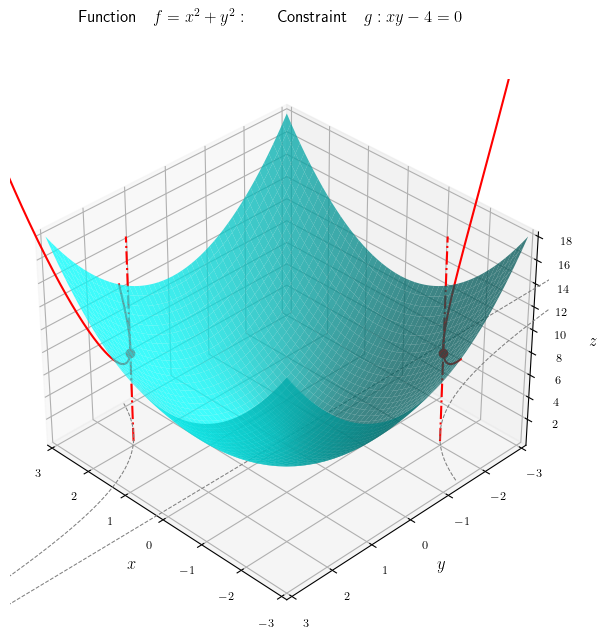

In [7]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection='3d')
fig.suptitle(supt, fontsize=12)

ax.set_aspect('auto', adjustable='box')
ax.set_xlim(minxf, maxxf)
ax.set_ylim(minyf, maxyf)
ax.set_zlim(minff, maxff)     # plot the surface
ax.plot_surface(xf, yf, ff, alpha = 0.75, color="cyan", label="Surface")
ax.view_init(elev=35, azim=135)

for j in range(ls):           # plot stationary points
    a, b, c = soln[j][0], soln[j][1], soln[j][2],
    ax.plot3D(a, b, c, 'o', color="red", label="Stationary points")
    ax.plot3D([a,a], [b,b], [minff,maxff], '-.', color="red")

xline = coords    
if l==1:
    yline = ylam(xline)
    zline = flam(xline,yline)
    ax.plot3D(xline, yline, zline, color="red", label="constraint")
    ax.plot(xline, yline, color="gray", ls="--", lw="0.75")
elif l==2:
    yline1 = ylam1(xline)
    zline1 = flam(xline,yline1)
    yline2 = ylam2(xline)
    zline2 = flam(xline,yline2)
    ax.plot3D(xline, yline1, zline1, color="red", label="constraint")
    ax.plot(xline, yline1, color="gray", ls="--", lw="0.75")
    ax.plot3D(xline, yline2, zline2, color="red")
    ax.plot(xline, yline2, color="gray", ls="--", lw="0.75")

ax.set_xlabel("$x$", fontsize=12)
ax.set_ylabel("$y$", fontsize=12)
ax.set_zlabel("$z$", fontsize=12)
ax.tick_params(labelcolor='k', labelsize='small', width=3)

plt.show()